In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score, fbeta_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_hastie_10_2
import warnings, gc, time, joblib
from datetime import datetime
from contextlib import contextmanager
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modélisation : Fonctions de visualisation et gain

In [ ]:
def business_metric_baseline(y_test,y_pred):
    fn_cost = 605915
    fp_cost = 423647
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    p = tp + fn
    n = tn + fp
    gain_1 = tn*fp_cost - fn*fn_cost
    return ((tn-n)-10*(fn-p))/(10*p)

def business_metric_normalized(y_test,y_pred):
    fn_cost = 605915
    fp_cost = 423647
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    p = tp + fn
    n = tn + fp
    gain_1 = tn*fp_cost - fn*fn_cost
    return (tn-10*(fn-p))/(n + 10*p)

def plot_classification_report(y_test, y_pred, y_pred_prob, beta = 2):
    conf_mat = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    df_cm = pd.DataFrame(conf_mat, index = [0,1], columns = [i for i in "01"])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    fig, ax = plt.subplots(1, 2, figsize = (15,7))
    sns.heatmap(df_cm, annot=True, ax = ax[0], cmap="Blues", fmt="d", cbar = False)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    ax[0].set_title("Confusion Matrix")
    ax[1].plot(fpr,tpr)
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    roc = round(100*roc_auc_score(y_test, y_pred),2)
    ax[1].text(1,0,"AUC : " + str(roc) + "%", fontsize=14, verticalalignment='bottom', horizontalalignment = 'right')
    plt.show()
    print("accuracy : ", round(100*accuracy_score(y_test, y_pred),2), "%")
    print("precision : ", round(100*tp/(tp+fp),2), "%")
    print("recall : ", round(100*tp/(tp+fn),2), "%")
    print("f"+str(beta) + " : ", round(fbeta_score(y_test,y_pred, beta = beta), 2))
    print("personalized_metric (baseline) : ", round(business_metric_baseline(y_test,y_pred),3))
    print("personalized_metric (normalized) : ", round(business_metric_normalized(y_test,y_pred),3))
    print("log_loss : ", round(log_loss(y_test,y_pred),2))
    print("AUC : ", roc, "%")

def variables_importance(df, importances_array):  
    importances = pd.DataFrame(data = df.columns[1:], columns = ["var"])
    importances["val"] = np.abs(importances_array)
    importances = importances.sort_values(by = ["val"], ascending  = False).reset_index(drop = True)
    fig, ax = plt.subplots(figsize = (15,15))
    sns.barplot(x = "val", y = "var", data = importances.iloc[:50], ax = ax)
    plt.title("Importance des variable - Regression Logistique")
    plt.show()

# make_scorer

def add_sampling_to_parameters(params, under_list = [0.3, 0.8], over_list = [0.3, 0.7]):
    over = SMOTE()
    under = RandomUnderSampler()
    params_under = params.copy()
    params_over = params.copy()
    params_under_over = params.copy()
    params_under["undersampling"] = [under]
    params_under["undersampling__sampling_strategy"] = under_list
    params_over["oversampling"] = [over]
    params_over["oversampling__sampling_strategy"] = [over_list]
    params_under_over["undersampling"] = [under]
    params_under_over["undersampling__sampling_strategy"] = under_list
    params_under_over["oversampling"] = [over]
    params_under_over["oversampling__sampling_strategy"] = over_list
    return [params, params_under, params_over, params_under_over]

In [ ]:
# ins = pd.read_csv(path_data + 'installments_payments.csv')
# application = pd.read_csv(path_data + 'application_train.csv')
# cheater = application[application["TARGET"]==1]
# cheater_info = cheater[["SK_ID_CURR","AMT_CREDIT"]].merge(ins[["SK_ID_CURR","AMT_PAYMENT"]], on = ["SK_ID_CURR"], how = "left")
# cheater_info_agg = cheater_info.groupby(["SK_ID_CURR"]).agg({"AMT_CREDIT":"mean","AMT_PAYMENT":"max"}).fillna(0).reset_index()
# cheater_info_agg["AMT_LOSS"] = cheater_info_agg["AMT_CREDIT"] - cheater_info_agg["AMT_PAYMENT"]
# fp_cost = cheater_info_agg["AMT_LOSS"].mean()
# interest_ratio = 0.0115
# fn_cost = (1 + interest_ratio)*application["AMT_CREDIT"].mean()
# print("fn_cost : ",fn_cost)
# print("fp_cost : ",fp_cost)

In [ ]:
# Code pour sauvegarder les models
# import joblib
# joblib.dump(dummy_clf, path_data + 'dummy_model.pkl')

# Modélisation : Choix du modèle



In [ ]:
path_data = "/content/drive/MyDrive/OPENCLASSROOM/Projet7/"
n_sample = 100000
df = pd.read_csv(path_data + "df.csv", sep = ",").sample(n = n_sample, random_state = 42)
scale_pos = df[df["TARGET"]==0].shape[0]/df[df["TARGET"]==1].shape[0]
X = df.drop(columns = ["TARGET","SK_ID_CURR"]).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
parameters_cv = [{"estimator" : [LogisticRegression(max_iter = 5000)],
                "estimator__class_weight":["balanced", None],
                "estimator__penalty":["l2"]},
                {"estimator" : [RandomForestClassifier()],
                "estimator__n_estimators": [100, 150],
                "estimator__max_depth":[10, 50],
                "estimator__min_samples_leaf":[500, 1000],
                "estimator__class_weight":["balanced"]},
                {"estimator" : [xgb.XGBClassifier()],
                 "estimator__n_estimators": [50, 100],
                 "estimator__max_depth":[10, 20],
                 "estimator__scale_pos_weight":[int(scale_pos)],
                 "estimator__min_samples_leaf":[500, 1000],
                 "estimator__learning_rate":[0.3]},
                {"estimator" : [LGBMClassifier()],
                "estimator__n_estimators":[100, 150],
                "estimator__learning_rate":[0.1],
                "estimator__num_leaves":[500, 1000],
                "estimator__max_depth":[3, 5, 10],
                "estimator__class_weight":["balanced"],
                "estimator__reg_alpha":[0.041545473],
                "estimator__reg_lambda":[0.0735294],
                "estimator__silent":[-1],
                "estimator__verbose":[-1]}]
parameter_cv_sampling = add_sampling_to_parameters(parameters_cv[0]) + add_sampling_to_parameters(parameters_cv[1]) + add_sampling_to_parameters(parameters_cv[2]) + add_sampling_to_parameters(parameters_cv[3])

In [ ]:
start = datetime.now()
scorer = make_scorer(business_metric_baseline)
metric = scorer
preprocessor = StandardScaler()
over = SMOTE()
under = RandomUnderSampler()
# X_train_rs,y_train_rs = over.fit_resample(X_train, y_train)
pipe = Pipeline([('transformer', preprocessor), ("undersampling", under), ("oversampling", over), ('estimator', LogisticRegression(max_iter=5000))])
search = GridSearchCV(pipe, parameter_cv_sampling, cv = 3, scoring = metric, return_train_score = True, verbose = 4, n_jobs = 2).fit(X_train, y_train)
y_pred = search.predict(X_test)
y_pred_prob = search.predict_proba(X_test)
end = datetime.now()
duration = (end - start).seconds
# Sauvegarde du model et des resultats
joblib.dump(search.best_estimator_, path_data + 'best_model.pkl')
pd.DataFrame.from_dict(search.cv_results_).to_csv("results_gridsearch.csv", index = False)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2;, score=(train=0.387, test=0.321) total time=   3.1s
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=None, estimator__penalty=l2;, score=(train=0.388, test=0.324) total time=   3.0s
[CV 3/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=None, estimator__penalty=l2;, score=(train=0.395, test=0.317) total time=   2.9s
[CV 2/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.389, test=0.318) total time=  16.7s
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[09:51:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[CV 3/3] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), estimator__learning_rate=0.3, estimator__max_depth=20, estimator__min_samples_leaf=1000, estimator__n_estimators=50, estimator__sc

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), estimator__learning_rate=0.3, estimator__max_depth=20, estimator__min_samples_leaf=1000, estimator__n_estimators=100, estimator__scale_pos_weight=11, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=R

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.463, test=0.362) total time=   1.3s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.456, test=0.365) total time=   1.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, sco

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.679, test=0.349) total time=   5.2s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.683, test=0.353) total time=   4.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.685, test=0.348) total time=   6.4s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.684, test=0.335) total time=   6.6s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, 

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.675, test=0.321) total time=   5.1s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.677, test=0.346) total time=   4.7s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;,

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.247, test=0.192) total time=   3.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.424, test=0.351) total time=   1.6s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=1

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.479, test=0.228) total time=   5.5s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.602, test=0.359) total time=   3.0s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=1

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.393, test=0.204) total time=   4.4s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.386, test=0.216) total time=   4.5s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.931, test=0.208) total time=  12.8s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.748, test=0.352) total time=   6.8s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimator

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.750, test=0.344) total time=   7.4s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.745, test=0.358) total time=   7.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.952, test=0.201) total time=  17.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.747, test=0.353) total time=   9.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimator

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.937, test=0.202) total time=  14.1s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.743, test=0.342) total time=   6.7s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimat

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=[0.3, 0.7];, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=[0.3, 0.7];, score=(train=nan, test=nan) total time=   0.3s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leav

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.953, test=0.214) total time=  17.2s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.751, test=0.340) total time=   9.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimato

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 1/3] END estimator=LGBMClassifier(), est

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.346, test=0.285) total time=   2.7s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 3/3] END estimator=LGBMClassifier(), e

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.555, test=0.289) total time=   4.9s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(),

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.564, test=0.280) total time=   4.8s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.561, test=0.295) total time=   4.8s
[CV 2/3] END estimator=LGBMClassifie

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.940, test=0.241) total time=  14.8s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.4s
[CV 2/3] END estimator=LGBMClassifier(

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

In [ ]:
results = pd.DataFrame.from_dict(search.cv_results_).sort_values(by = ["mean_test_score"], ascending = False).reset_index(drop = True)
results = results[['param_estimator', 'mean_fit_time', 'mean_train_score', 'mean_test_score']]
results.head()

,param_estimator,mean_fit_time,mean_train_score,mean_test_score
0,"LGBMClassifier(class_weight='balanced', max_de...",1.855972,0.454243,0.368530
1,"LGBMClassifier(class_weight='balanced', max_de...",1.858243,0.461025,0.368164
2,"LGBMClassifier(class_weight='balanced', max_de...",1.274413,0.460292,0.363435
3,"LGBMClassifier(class_weight='balanced', max_de...",1.258001,0.460667,0.362059
4,"LGBMClassifier(class_weight='balanced', max_de...",1.075027,0.438077,0.360686


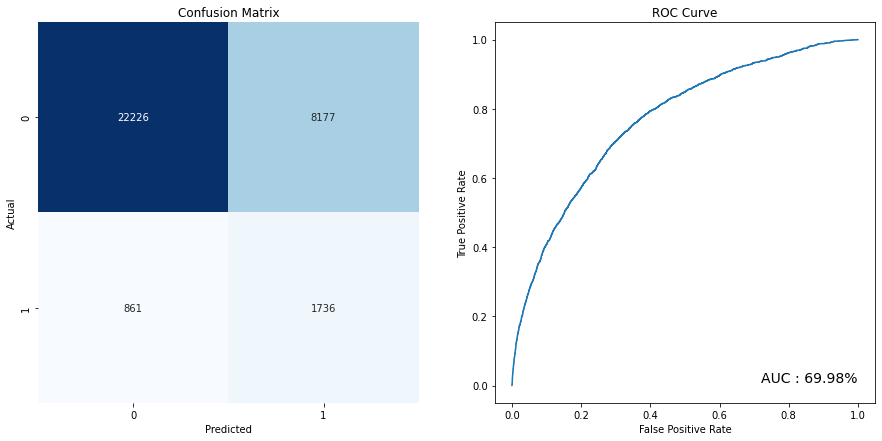

accuracy :  72.61 %
precision :  17.51 %
recall :  66.85 %
f2 :  42.76
log_loss :  9.46
AUC :  69.98 %


In [ ]:
plot_classification_report(y_test, y_pred, y_pred_prob)

# Modélisation : Analyse du model

In [ ]:
path_data = "/content/drive/MyDrive/OPENCLASSROOM/Projet7/"
n_sample = 100000
df = pd.read_csv(path_data + "df.csv", sep = ",").sample(n = n_sample, random_state = 42)
scale_pos = df[df["TARGET"]==0].shape[0]/df[df["TARGET"]==1].shape[0]
X = df.drop(columns = ["TARGET","SK_ID_CURR"]).values
y = df["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Loading the best model
loaded_model = joblib.load(path_data + 'best_model.pkl')
result = loaded_model.score(X_test, y_test)
y_pred_test = loaded_model.predict(X_test)
y_pred_proba_test = loaded_model.predict_proba(X_test)
# print(result)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator NearestNeighbors from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own ris

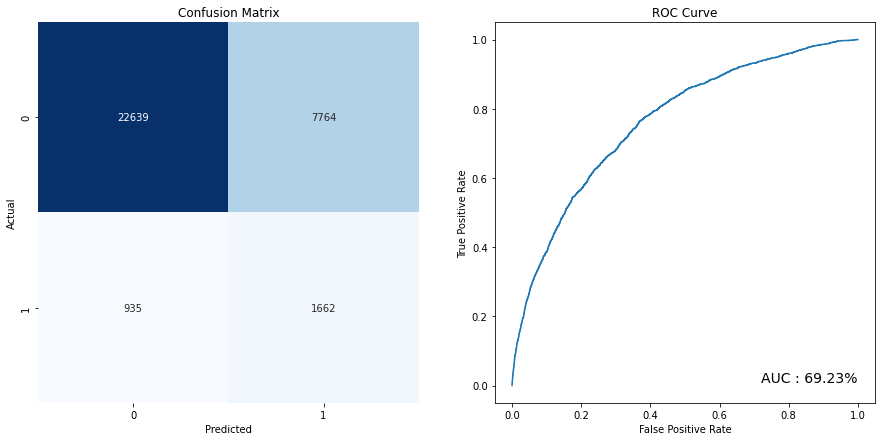

accuracy :  73.64 %
precision :  17.63 %
recall :  64.0 %
f2 :  0.42
personalized_metric (baseline) :  0.341
personalized_metric (normalized) :  0.696
log_loss :  9.1
AUC :  69.23 %


In [ ]:
plot_classification_report(y_test, y_pred_test, y_pred_proba_test)